<a href="https://colab.research.google.com/github/helenosss/sales-analytics-project/blob/main/sales_analytics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Files/Final Project

/content/drive/MyDrive/Files/Final Project


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Завантаження та опис датасету

In [ ]:
events_df = pd.read_csv("events.csv")
products_df = pd.read_csv("products.csv")
countries_df = pd.read_csv("countries.csv")

In [ ]:
events_df.head()

,Order ID,Order Date,Ship Date,Order Priority,Country Code,Product ID,Sales Channel,Units Sold,Unit Price,Unit Cost
0,100640618,10/8/2014,10/18/2014,M,NOR,2103,Online,650.0,205.70,117.11
1,100983083,8/11/2016,8/11/2016,C,SRB,2103,Offline,1993.0,205.70,117.11
2,101025998,7/18/2014,8/11/2014,M,NaN,7940,Online,4693.0,668.27,502.54
3,102230632,5/13/2017,6/13/2017,L,MNE,2455,Online,1171.0,109.28,35.84
4,103435266,8/11/2012,9/18/2012,H,SRB,1270,Offline,7648.0,47.45,31.79


Датафрейм events_df містить такі стовпці: id замовлення, дата замовлення, дата відправлення, пріоритетність замовлення, код країни, id продукту, канал збуту, кількість проданих одиниць, ціна за одиницю, собівартість одиниці.

In [ ]:
products_df.head()

,id,item_type
0,2103,Cereal
1,7940,Household
2,2455,Clothes
3,1270,Beverages
4,8681,Office Supplies


Датафрейм products_df містить стовпці з інформацією про id продукту та тип продукту.

In [ ]:
countries_df.head()

,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
1,Åland Islands,AX,ALA,Europe,Northern Europe
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
4,American Samoa,AS,ASM,Oceania,Polynesia


Таблиця countries_df містить стовпці з назвою країни, дволітерним кодом країни, трилітерним кодом країни, регіоном та субрегіоном.

Таблиці events_df та products_df поєднуються за полями Product ID та id;
events_df та countries_df - за полями Country Code та alpha-3.

# Очищення даних

### Робота з пропущеними значеннями

##### Таблиця events_df

In [ ]:
events_df.columns = events_df.columns.str.lower().str.replace(" ", "_").str.replace("-", "_")

In [ ]:
events_df.isna().sum()

,0
order_id,0
order_date,0
ship_date,0
order_priority,0
country_code,82
product_id,0
sales_channel,0
units_sold,2
unit_price,0
unit_cost,0


In [ ]:
events_df.isna().sum() / events_df.shape[0] * 100

,0
order_id,0.000000
order_date,0.000000
ship_date,0.000000
order_priority,0.000000
country_code,6.165414
product_id,0.000000
sales_channel,0.000000
units_sold,0.150376
unit_price,0.000000
unit_cost,0.000000


У таблиці events_df є пропущені значення у колонках country_code (6.17% від загальної кількості значень) та Units Sold (0.15% від загальної кількості). Причиною виникнення може бути відсутність інформації.

Видалення рядків з пропущеними значеннями може вплинути на результати аналізу, бо їх частка є досить великою. Порожні значення у колонці units_sold заповнено медіаною. У колонці country_code порожні значення замінено на "Unknown".

In [ ]:
events_df["units_sold"] = events_df["units_sold"].fillna(events_df["units_sold"].median())
events_df["country_code"] = events_df["country_code"].fillna("Unknown")

##### Таблиця products_df

In [ ]:
products_df.isna().sum()

,0
id,0
item_type,0


Пропущених значень немає.

##### Таблиця countries_df

In [ ]:
countries_df.columns = countries_df.columns.str.lower().str.replace(" ", "_").str.replace("-", "_")
countries_df.isna().sum()

,0
name,0
alpha_2,1
alpha_3,0
region,1
sub_region,1


In [ ]:
countries_df.isna().sum() / countries_df.shape[0] * 100

,0
name,0.000000
alpha_2,0.401606
alpha_3,0.000000
region,0.401606
sub_region,0.401606


У таблиці countries_df є пропущені значення у стовпцях region, sub_region та alpha_2. Їх було заповнено вручну для того, щоб могти в подальшому проводити аналіз за регіонами та субрегіонами.

In [ ]:
countries_df[countries_df["alpha_2"].isna() | countries_df["region"].isna() | countries_df["sub_region"].isna()]

,name,alpha_2,alpha_3,region,sub_region
8,Antarctica,AQ,ATA,NaN,NaN
153,Namibia,NaN,NAM,Africa,Sub-Saharan Africa


In [ ]:
countries_df.loc[countries_df["name"] == "Antarctica", ["region", "sub_region"]] = "Antarctica"
countries_df.loc[countries_df["name"] == "Namibia", "alpha_2"] = "NA"

### Перевірка коректності типів даних

##### Таблиця events_df

In [ ]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        1330 non-null   int64  
 1   order_date      1330 non-null   object 
 2   ship_date       1330 non-null   object 
 3   order_priority  1330 non-null   object 
 4   country_code    1330 non-null   object 
 5   product_id      1330 non-null   int64  
 6   sales_channel   1330 non-null   object 
 7   units_sold      1330 non-null   float64
 8   unit_price      1330 non-null   float64
 9   unit_cost       1330 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 104.0+ KB


У таблиці events_df некоректно визначено тип даних у стопвці order_date та ship_date. Перетворимо його на datetime.

In [ ]:
events_df['order_date'] = pd.to_datetime(events_df['order_date'], format = '%m/%d/%Y')
events_df['ship_date'] = pd.to_datetime(events_df['ship_date'], format = '%m/%d/%Y')

In [ ]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        1330 non-null   int64         
 1   order_date      1330 non-null   datetime64[ns]
 2   ship_date       1330 non-null   datetime64[ns]
 3   order_priority  1330 non-null   object        
 4   country_code    1330 non-null   object        
 5   product_id      1330 non-null   int64         
 6   sales_channel   1330 non-null   object        
 7   units_sold      1330 non-null   float64       
 8   unit_price      1330 non-null   float64       
 9   unit_cost       1330 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(3)
memory usage: 104.0+ KB


##### Таблиця products_df

In [ ]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         12 non-null     int64 
 1   item_type  12 non-null     object
dtypes: int64(1), object(1)
memory usage: 324.0+ bytes


Усі типи даних коректні.

##### Таблиця countries_df

In [ ]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        249 non-null    object
 1   alpha_2     249 non-null    object
 2   alpha_3     249 non-null    object
 3   region      249 non-null    object
 4   sub_region  249 non-null    object
dtypes: object(5)
memory usage: 9.9+ KB


Усі типи даних коректні.

### Дослідження даних на наявність дублікатів

In [ ]:
import re

uppercase_columns = ["order_priority", "country_code", "alpha_2", "alpha_3"]

def clean_data(df):
  """
  Функція очищує зайві пробіли та уніфікує регістр у колонках
  (колонки з абревіатурами переводить в аперкейс, колонки зі звичайними словами записує з великої літери)
  """
  for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
    if col in uppercase_columns:
      df[col] = df[col].apply(lambda x: x.title() if x == "Unknown" else x.upper())
    else:
      df[col] = df[col].str.title()
  return df

events_df = clean_data(events_df)
products_df = clean_data(products_df)
countries_df = clean_data(countries_df)

In [ ]:
print(events_df.duplicated().sum())

0


In [ ]:
print(products_df.duplicated().sum())

0


In [ ]:
print(countries_df.duplicated().sum())

0


In [ ]:
print(events_df["order_id"].duplicated().sum())

0


In [ ]:
print(products_df["id"].duplicated().sum())

0


Дублікатів даних не виявлено.

### Дослідження на наявність аномалій

In [ ]:
events_df.describe()

,order_id,order_date,ship_date,product_id,units_sold,unit_price,unit_cost
count,1.330000e+03,1330,1330,1330.000000,1330.000000,1330.000000,1330.000000
mean,5.412048e+08,2013-10-12 06:09:12.180451072,2013-11-06 00:46:33.383458816,5788.096241,4952.216541,264.893541,187.246812
min,1.006406e+08,2010-01-01 00:00:00,2010-01-10 00:00:00,1270.000000,2.000000,9.330000,6.920000
25%,3.190004e+08,2011-12-16 06:00:00,2012-01-03 00:00:00,3127.000000,2360.750000,81.730000,35.840000
50%,5.387164e+08,2013-10-17 00:00:00,2013-11-09 00:00:00,5988.000000,4962.000000,154.060000,97.440000
75%,7.544628e+08,2015-08-28 18:00:00,2015-10-03 18:00:00,8681.000000,7458.750000,437.200000,263.330000
max,9.998797e+08,2017-07-23 00:00:00,2017-08-31 00:00:00,8969.000000,9999.000000,668.270000,524.960000
std,2.573882e+08,NaN,NaN,2820.728878,2903.012194,217.323460,176.158873


На цьому етапі явних аномалій не виявлено.

In [ ]:
events_df[events_df["ship_date"] < events_df["order_date"]]

,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost


У таблиці немає записів, де дата відправлення раніша за дату замовлення.

In [ ]:
events_df[events_df["unit_cost"] > events_df["unit_price"]]

,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost


Також немає записів, де собівартість вища, ніж ціна.

In [ ]:
events_df["order_priority"].value_counts()

,count
order_priority,
M,354
H,335
L,334
C,307


In [ ]:
events_df["sales_channel"].value_counts()

,count
sales_channel,
Offline,667
Online,663


Немає рідкісних чи дивних значень.

# Аналіз та візуалізація

### Об'єднання таблиць в один датафрейм

In [ ]:
df = pd.merge(events_df, products_df, how = "inner", left_on = "product_id", right_on = "id")
df = pd.merge(df, countries_df, how = "left", left_on = "country_code", right_on = "alpha_3")
df.head()

,order_id,order_date,ship_date,order_priority,country_code,product_id,sales_channel,units_sold,unit_price,unit_cost,id,item_type,name,alpha_2,alpha_3,region,sub_region
0,100640618,2014-10-08,2014-10-18,M,NOR,2103,Online,650.0,205.70,117.11,2103,Cereal,Norway,NO,NOR,Europe,Northern Europe
1,100983083,2016-08-11,2016-08-11,C,SRB,2103,Offline,1993.0,205.70,117.11,2103,Cereal,Serbia,RS,SRB,Europe,Southern Europe
2,101025998,2014-07-18,2014-08-11,M,Unknown,7940,Online,4693.0,668.27,502.54,7940,Household,NaN,NaN,NaN,NaN,NaN
3,102230632,2017-05-13,2017-06-13,L,MNE,2455,Online,1171.0,109.28,35.84,2455,Clothes,Montenegro,ME,MNE,Europe,Southern Europe
4,103435266,2012-08-11,2012-09-18,H,SRB,1270,Offline,7648.0,47.45,31.79,1270,Beverages,Serbia,RS,SRB,Europe,Southern Europe


In [ ]:
df = df.drop(columns=["id"]).drop(columns=["alpha_2"]).drop(columns=["alpha_3"])
df.shape

(1330, 14)

In [ ]:
df.rename(columns={"name": "country_name"}, inplace=True)
df = df[["order_id", "order_date", "ship_date", "order_priority", "country_code", "country_name", "region",
         "sub_region", "product_id", "item_type", "sales_channel", "units_sold", "unit_price", "unit_cost"]]
df.head()

,order_id,order_date,ship_date,order_priority,country_code,country_name,region,sub_region,product_id,item_type,sales_channel,units_sold,unit_price,unit_cost
0,100640618,2014-10-08,2014-10-18,M,NOR,Norway,Europe,Northern Europe,2103,Cereal,Online,650.0,205.70,117.11
1,100983083,2016-08-11,2016-08-11,C,SRB,Serbia,Europe,Southern Europe,2103,Cereal,Offline,1993.0,205.70,117.11
2,101025998,2014-07-18,2014-08-11,M,Unknown,NaN,NaN,NaN,7940,Household,Online,4693.0,668.27,502.54
3,102230632,2017-05-13,2017-06-13,L,MNE,Montenegro,Europe,Southern Europe,2455,Clothes,Online,1171.0,109.28,35.84
4,103435266,2012-08-11,2012-09-18,H,SRB,Serbia,Europe,Southern Europe,1270,Beverages,Offline,7648.0,47.45,31.79


In [ ]:
df.isna().sum()

,0
order_id,0
order_date,0
ship_date,0
order_priority,0
country_code,0
country_name,82
region,82
sub_region,82
product_id,0
item_type,0


In [ ]:
df["country_name"] = df["country_name"].fillna("Unknown")
df["region"] = df["region"].fillna("Unknown")
df["sub_region"] = df["sub_region"].fillna("Unknown")

### Розрахунок ключових метрик

In [ ]:
print(f"Загальна кількість замовлень: {df['order_id'].count()}")

print(f"Загальна кількість проданих одиниць: {int(df['units_sold'].sum())}")

df["revenue"] = df["units_sold"] * df["unit_price"]
print(f"Загальний дохід: {df['revenue'].sum()}")

df["total_cost"] = df["units_sold"] * df["unit_cost"]
df["profit"] = df["revenue"] - df["total_cost"]
print(f"Загальний прибуток: {round(df['profit'].sum(), 2)}")

print(f"Кількість охоплених країн: {len(df['country_name'].unique()) - 1}") # Віднімаємо 1, щоб не враховувати дані про невідомі країни

print(f"Найстаріше замовлення: {df['order_date'].min()}")
print(f"Найновіше замовлення: {df['order_date'].max()}")

Загальна кількість замовлень: 1330
Загальна кількість проданих одиниць: 6586448
Загальний дохід: 1704628370.65
Загальний прибуток: 501842633.12
Кількість охоплених країн: 45
Найстаріше замовлення: 2010-01-01 00:00:00
Найновіше замовлення: 2017-07-23 00:00:00


In [ ]:
df.head()

,order_id,order_date,ship_date,order_priority,country_code,country_name,region,sub_region,product_id,item_type,sales_channel,units_sold,unit_price,unit_cost,revenue,total_cost,profit
0,100640618,2014-10-08,2014-10-18,M,NOR,Norway,Europe,Northern Europe,2103,Cereal,Online,650.0,205.70,117.11,133705.00,76121.50,57583.50
1,100983083,2016-08-11,2016-08-11,C,SRB,Serbia,Europe,Southern Europe,2103,Cereal,Offline,1993.0,205.70,117.11,409960.10,233400.23,176559.87
2,101025998,2014-07-18,2014-08-11,M,Unknown,Unknown,Unknown,Unknown,7940,Household,Online,4693.0,668.27,502.54,3136191.11,2358420.22,777770.89
3,102230632,2017-05-13,2017-06-13,L,MNE,Montenegro,Europe,Southern Europe,2455,Clothes,Online,1171.0,109.28,35.84,127966.88,41968.64,85998.24
4,103435266,2012-08-11,2012-09-18,H,SRB,Serbia,Europe,Southern Europe,1270,Beverages,Offline,7648.0,47.45,31.79,362897.60,243129.92,119767.68


### Аналіз продажів

##### Доходи в розрізі категорій товарів

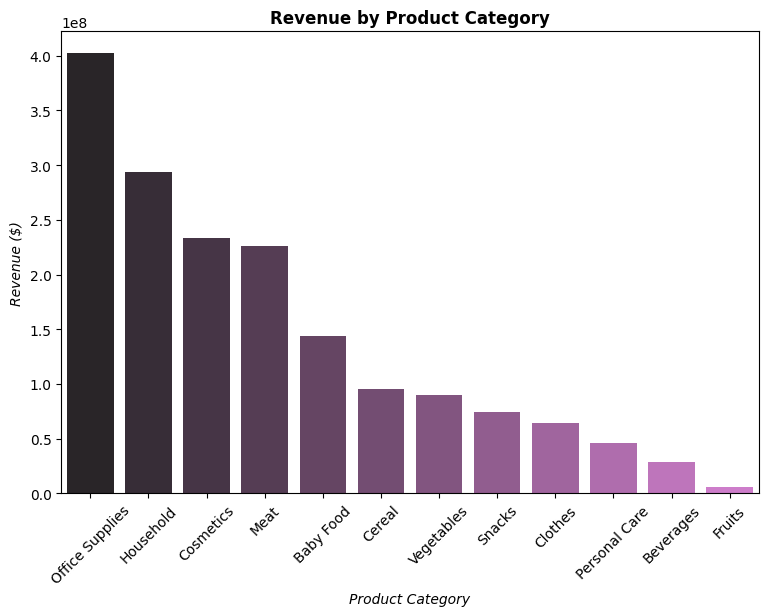

In [ ]:
revenue_by_category = df.groupby("item_type")["revenue"].sum().sort_values(ascending = False)

plt.figure(figsize = (9, 6))
sns.barplot(x = revenue_by_category.index, y = revenue_by_category.values, hue = revenue_by_category.index, palette="dark:orchid")
plt.title("Revenue by Product Category", fontweight = "bold")
plt.xlabel("Product Category", fontstyle = "italic")
plt.ylabel("Revenue ($)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найбільше доходів приносять категорії Office Supplies, Household та Cosmetics, найменше - Personal Care, Beverages та Fruits.

##### Доходи в розрізі країн та регіонів

Замовлення для яких відсутня інформація про країну чи регіон при аналізі не враховано.

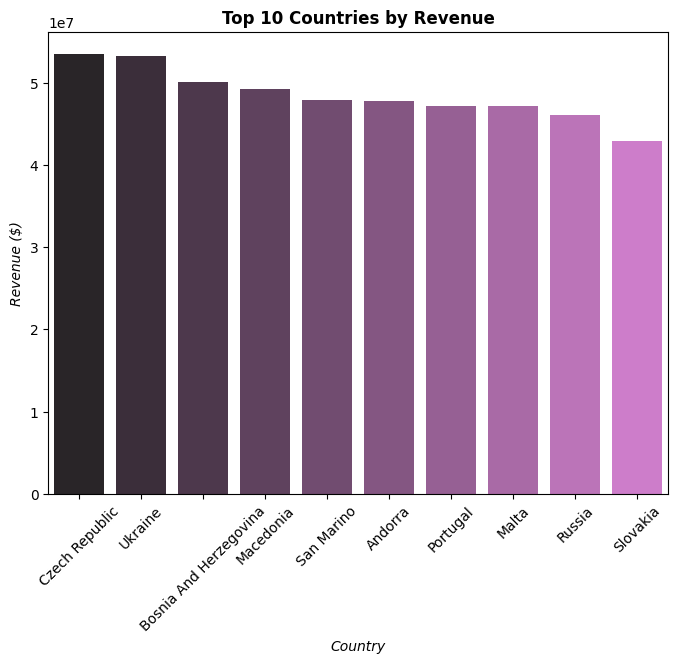

In [ ]:
revenue_by_country = df.groupby("country_name")["revenue"].sum().sort_values(ascending = False).reset_index()
revenue_by_country = revenue_by_country[revenue_by_country["country_name"] != "Unknown"]
top_10_countries_by_revenue = revenue_by_country.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_10_countries_by_revenue, x = "country_name", y = "revenue", hue = "country_name", palette="dark:orchid")
plt.title("Top 10 Countries by Revenue", fontweight = "bold")
plt.xlabel("Country", fontstyle = "italic")
plt.ylabel("Revenue ($)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

За доходами домінують такі країни, як Чехія, Україна, Боснія і Герцеговина, Македонія, Сан-Марино та інші.

In [ ]:
fig = px.choropleth(
    revenue_by_country,
    locations="country_name",
    locationmode="country names",
    color="revenue",
    title="<b>Total Revenue by Country</b>",
    color_continuous_scale="Sunset",
    range_color=(revenue_by_country["revenue"].min(), revenue_by_country["revenue"].max())
)
fig.update_layout(width=800, height=500)

fig.show()

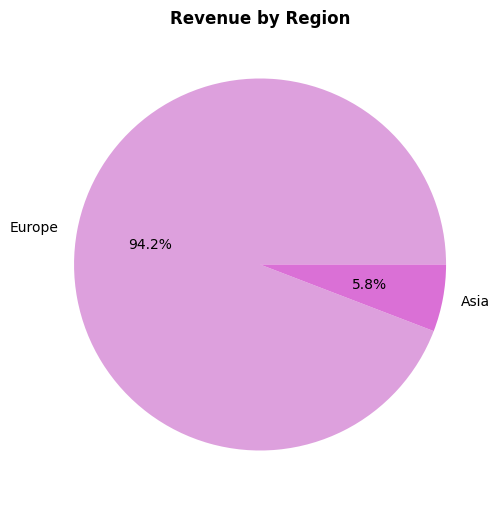

In [ ]:
revenue_by_region = df.groupby("region")["revenue"].sum().sort_values(ascending = False).reset_index()
revenue_by_region = revenue_by_region[revenue_by_region["region"] != "Unknown"]

plt.figure(figsize = (6,8))
plt.pie(revenue_by_region["revenue"], labels = revenue_by_region["region"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Revenue by Region", fontweight = "bold")
plt.show()

Значна частина доходів (94.2%) надходить з Європи. Лише 5.8 % - з Азії.

##### Доходи в розрізі каналів продажу

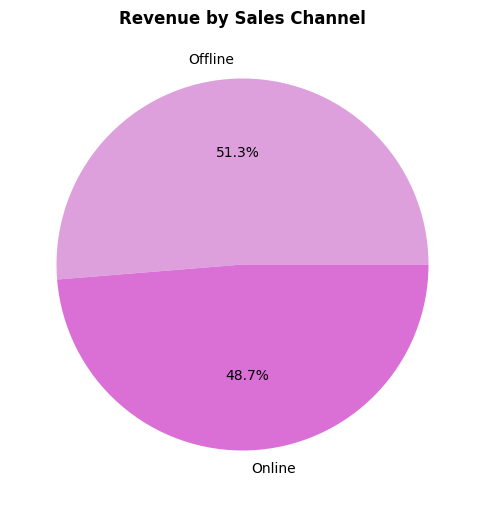

In [ ]:
revenue_by_channel = df.groupby("sales_channel")["revenue"].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize = (6,8))
plt.pie(revenue_by_channel["revenue"], labels = revenue_by_channel["sales_channel"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Revenue by Sales Channel", fontweight = "bold")
plt.show()

Доходи з онлайн- і офлайн-каналів розподілені майже порівну.

##### Витрати в розрізі категорій товарів

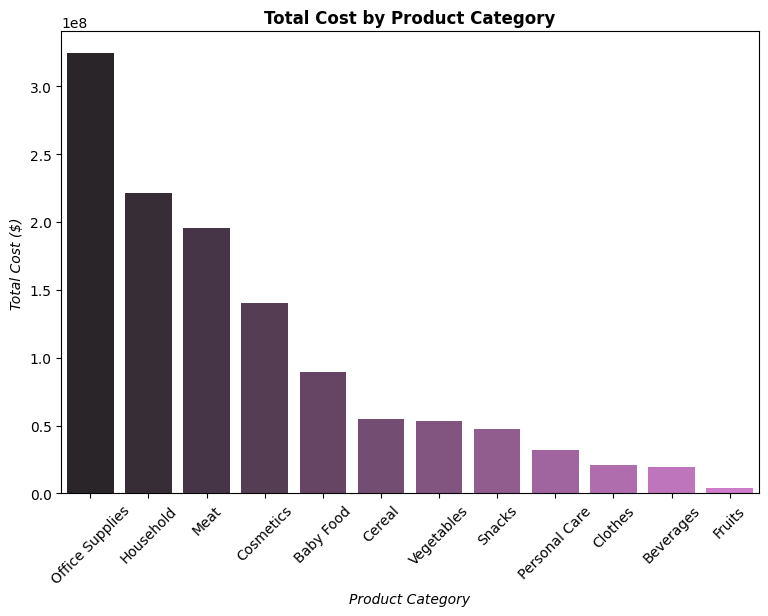

In [ ]:
cost_by_category = df.groupby("item_type")["total_cost"].sum().sort_values(ascending = False)

plt.figure(figsize = (9, 6))
sns.barplot(x = cost_by_category.index, y = cost_by_category.values, hue = cost_by_category.index, palette="dark:orchid")
plt.title("Total Cost by Product Category", fontweight = "bold")
plt.xlabel("Product Category", fontstyle = "italic")
plt.ylabel("Total Cost ($)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найвищі витрати спостерігаються у категоріях Office Supplies, Household та Meat.

##### Витрати в розрізі країн та регіонів

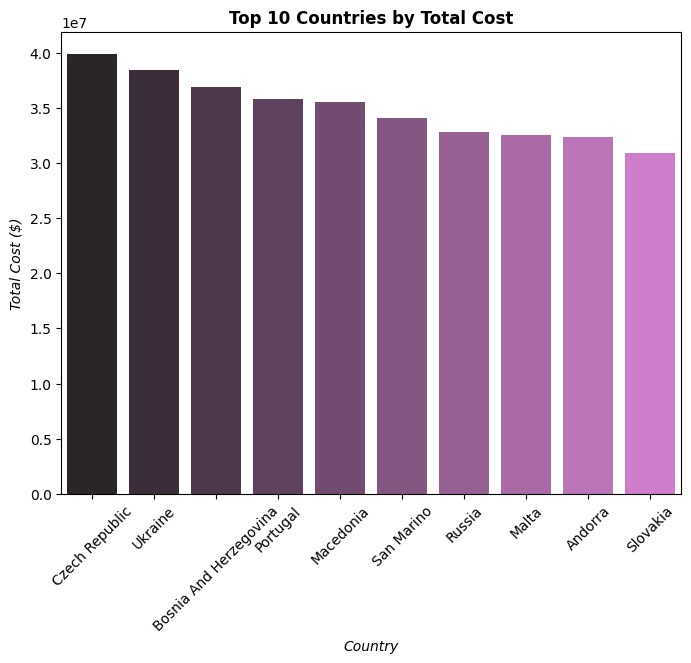

In [ ]:
cost_by_country = df.groupby("country_name")["total_cost"].sum().sort_values(ascending = False).reset_index()
cost_by_country = cost_by_country[cost_by_country["country_name"] != "Unknown"]
top_10_countries_by_cost = cost_by_country.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_10_countries_by_cost, x = "country_name", y = "total_cost", hue = "country_name", palette="dark:orchid")
plt.title("Top 10 Countries by Total Cost", fontweight = "bold")
plt.xlabel("Country", fontstyle = "italic")
plt.ylabel("Total Cost ($)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

За витратами домінують Чехія, Україна, Боснія і Герцеговина, Португалія та інші.

In [ ]:
fig = px.choropleth(
    cost_by_country,
    locations="country_name",
    locationmode="country names",
    color="total_cost",
    title="<b>Total Cost by Country</b>",
    color_continuous_scale="Sunset")

fig.update_layout(width=800, height=500)

fig.show()

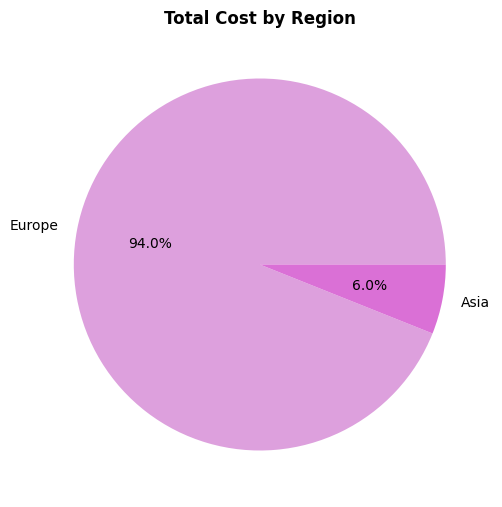

In [ ]:
cost_by_region = df.groupby("region")["total_cost"].sum().sort_values(ascending = False).reset_index()
cost_by_region = cost_by_region[cost_by_region["region"] != "Unknown"]

plt.figure(figsize = (6,8))
plt.pie(cost_by_region["total_cost"], labels = cost_by_region["region"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Total Cost by Region", fontweight = "bold")
plt.show()

За витратами домінує Європа (94%). Для Азії витрати становлять лише 5%.

##### Витрати в розрізі каналів продажу

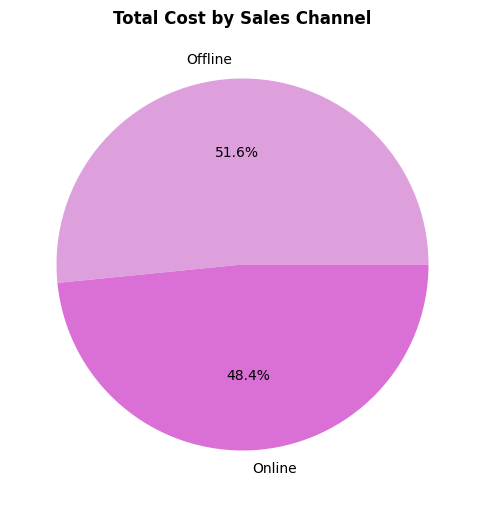

In [ ]:
cost_by_channel = df.groupby("sales_channel")["total_cost"].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize = (6,8))
plt.pie(cost_by_channel["total_cost"], labels = cost_by_channel["sales_channel"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Total Cost by Sales Channel", fontweight = "bold")
plt.show()

За каналами продажу витрати розподілені майже порівну.

##### Прибутки в розрізі категорій

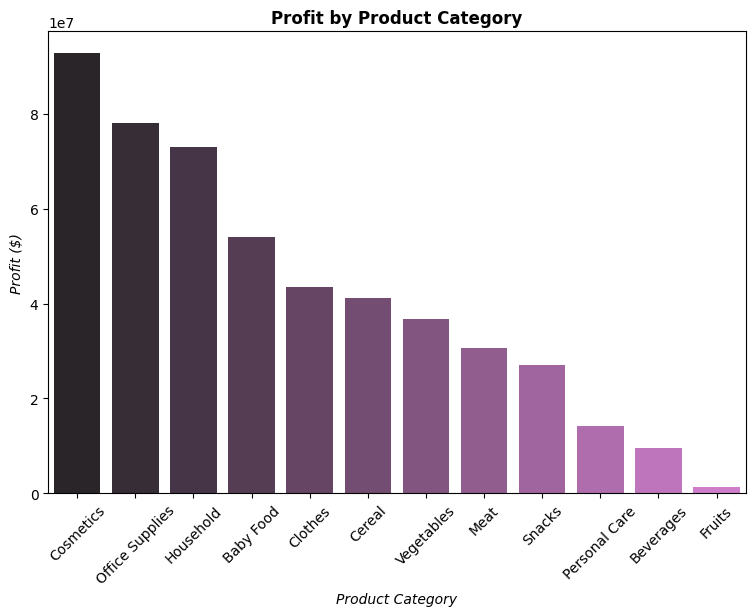

In [ ]:
profit_by_category = df.groupby("item_type")["profit"].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize = (9, 6))
sns.barplot(data = profit_by_category, x = "item_type", y = "profit", hue = "item_type", palette="dark:orchid")
plt.title("Profit by Product Category", fontweight = "bold")
plt.xlabel("Product Category", fontstyle = "italic")
plt.ylabel("Profit ($)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найбільше прибутків принесли категорії Cosmetics, Office Supplies та Household.

##### Прибутки в розрізі країн та регіонів

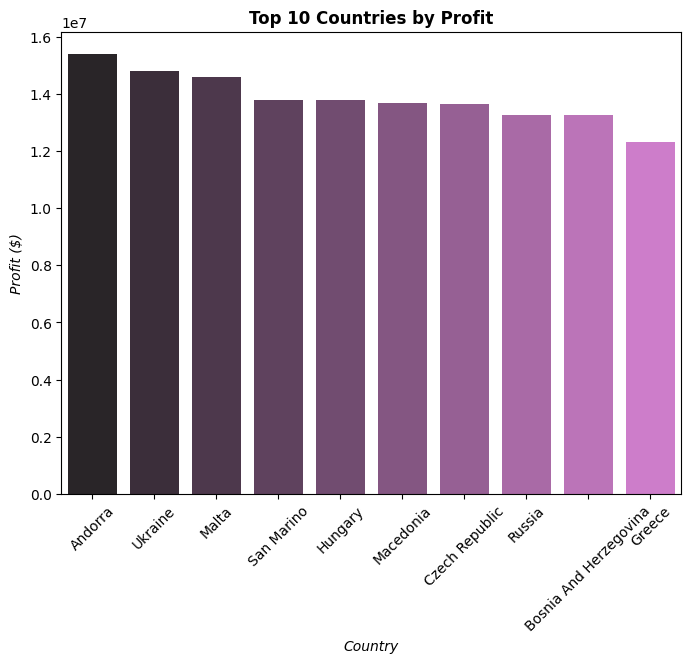

In [ ]:
profit_by_country = df.groupby("country_name")["profit"].sum().sort_values(ascending = False).reset_index()
profit_by_country = profit_by_country[profit_by_country["country_name"] != "Unknown"]
top_10_countries_by_profit = profit_by_country.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_10_countries_by_profit, x = "country_name", y = "profit", hue = "country_name", palette="dark:orchid")
plt.title("Top 10 Countries by Profit", fontweight = "bold")
plt.xlabel("Country", fontstyle = "italic")
plt.ylabel("Profit ($)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найбільше прибутків надходить з Андорри, України, Мальти, Сан-Марино, Угорщини.

In [ ]:
fig = px.choropleth(
    profit_by_country,
    locations="country_name",
    locationmode="country names",
    color="profit",
    title="<b>Profit by Country</b>",
    color_continuous_scale="Sunset")

fig.update_layout(width=800, height=500)

fig.show()

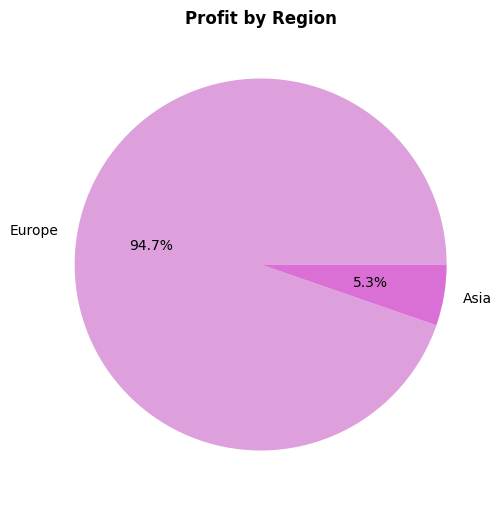

In [ ]:
profit_by_region = df.groupby("region")["profit"].sum().sort_values(ascending = False).reset_index()
profit_by_region = profit_by_region[profit_by_region["region"] != "Unknown"]

plt.figure(figsize = (6,8))
plt.pie(profit_by_region["profit"], labels = profit_by_region["region"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Profit by Region", fontweight = "bold")
plt.show()

Значна частина прибутків надходить з Європи (94.7%) і лише невелика - з Азії (5.3%).

##### Прибутки в розрізі каналів продажу

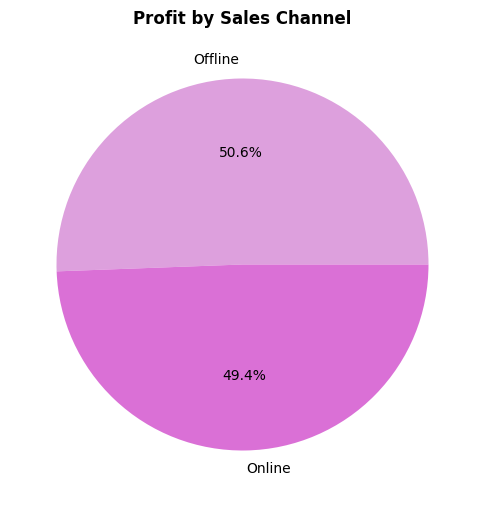

In [ ]:
profit_by_channel = df.groupby("sales_channel")["profit"].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize = (6,8))
plt.pie(profit_by_channel["profit"], labels = profit_by_channel["sales_channel"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Profit by Sales Channel", fontweight = "bold")
plt.show()

Обидва канали продажів приносять приблизно однакову кількість прибутків.

##### Популярність товарів у розрізі категорій

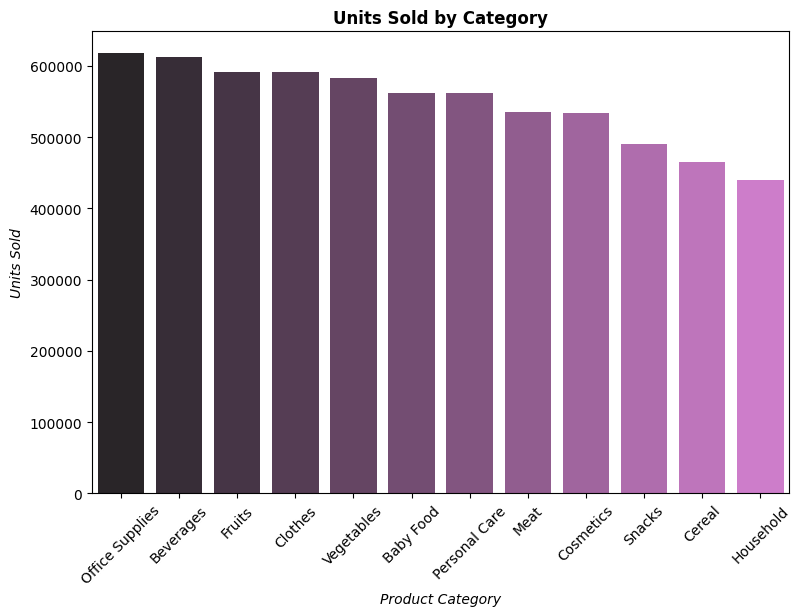

In [ ]:
units_sold_by_category = df.groupby("item_type")["units_sold"].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize = (9, 6))
sns.barplot(data = units_sold_by_category, x = "item_type", y = "units_sold", hue = "item_type", palette="dark:orchid")
plt.title("Units Sold by Category", fontweight = "bold")
plt.xlabel("Product Category", fontstyle = "italic")
plt.ylabel("Units Sold", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найбільше одиниць товарів замовлено у категоріях Office Supplies, Beverages та Fruits.

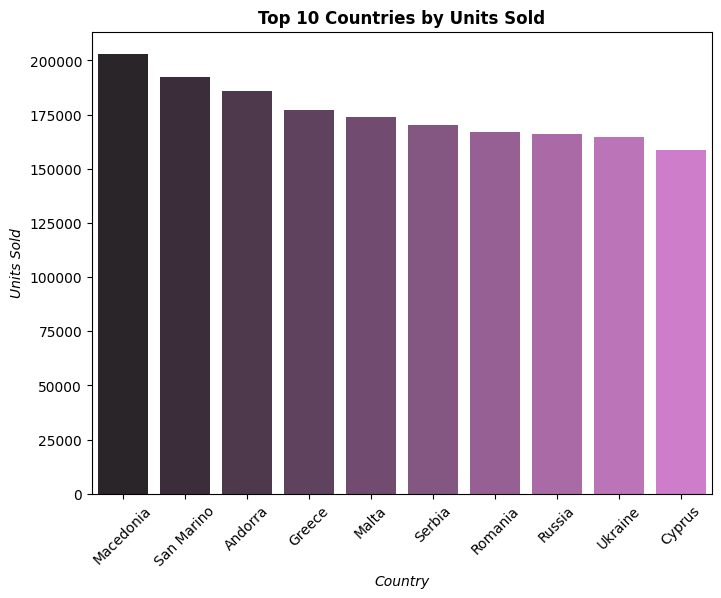

In [ ]:
units_sold_by_country = df.groupby("country_name")["units_sold"].sum().sort_values(ascending = False).reset_index()
units_sold_by_country = units_sold_by_country[units_sold_by_country["country_name"] != "Unknown"]
top_10_countries_by_units_sold = units_sold_by_country.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_10_countries_by_units_sold, x = "country_name", y = "units_sold", hue = "country_name", palette="dark:orchid")
plt.title("Top 10 Countries by Units Sold", fontweight = "bold")
plt.xlabel("Country", fontstyle = "italic")
plt.ylabel("Units Sold", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найбільше товарів замовили у Македонії, Сан-Марино, Андоррі, Греції та Мальті.

In [ ]:
fig = px.choropleth(
    units_sold_by_country,
    locations="country_name",
    locationmode="country names",
    color="units_sold",
    title="<b>Units Sold by Country</b>",
    color_continuous_scale="Sunset")

fig.update_layout(width=800, height=500)

fig.show()

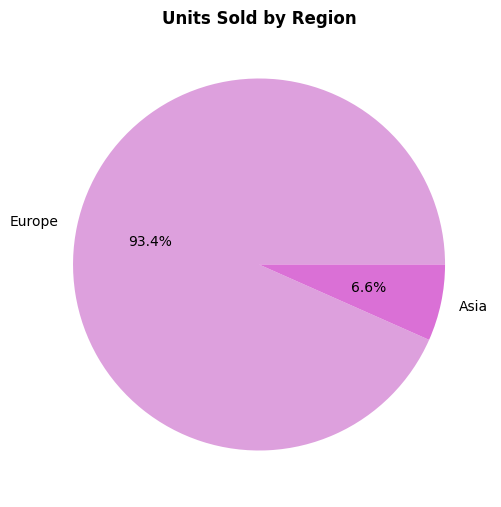

In [ ]:
units_sold_by_region = df.groupby("region")["units_sold"].sum().sort_values(ascending = False).reset_index()
units_sold_by_region = units_sold_by_region[units_sold_by_region["region"] != "Unknown"]

plt.figure(figsize = (6,8))
plt.pie(units_sold_by_region["units_sold"], labels = units_sold_by_region["region"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Units Sold by Region", fontweight = "bold")
plt.show()

93.4% товарів замовили з Європи, 6.6% - з Азії.

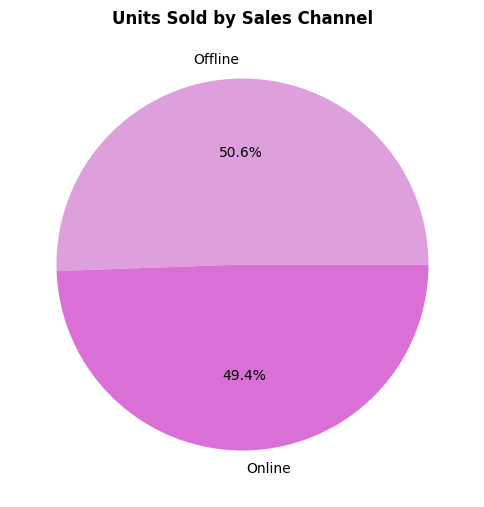

In [ ]:
units_sold_by_channel = df.groupby("sales_channel")["units_sold"].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize = (6,8))
plt.pie(units_sold_by_channel["units_sold"], labels = units_sold_by_channel["sales_channel"], autopct='%1.1f%%', colors = ["plum", "orchid"])
plt.title("Units Sold by Sales Channel", fontweight = "bold")
plt.show()

Приблизно однакову кількість товарів замовлено з онлайн- та офлайн-каналів.

### Аналіз інтервалу часу між замовленням та його відвантаженням

##### За категоріями

In [ ]:
df["interval"] = df["ship_date"] - df["order_date"]
df["interval"] = df["interval"].dt.days
df.head()

,order_id,order_date,ship_date,order_priority,country_code,country_name,region,sub_region,product_id,item_type,sales_channel,units_sold,unit_price,unit_cost,revenue,total_cost,profit,interval
0,100640618,2014-10-08,2014-10-18,M,NOR,Norway,Europe,Northern Europe,2103,Cereal,Online,650.0,205.70,117.11,133705.00,76121.50,57583.50,10
1,100983083,2016-08-11,2016-08-11,C,SRB,Serbia,Europe,Southern Europe,2103,Cereal,Offline,1993.0,205.70,117.11,409960.10,233400.23,176559.87,0
2,101025998,2014-07-18,2014-08-11,M,Unknown,Unknown,Unknown,Unknown,7940,Household,Online,4693.0,668.27,502.54,3136191.11,2358420.22,777770.89,24
3,102230632,2017-05-13,2017-06-13,L,MNE,Montenegro,Europe,Southern Europe,2455,Clothes,Online,1171.0,109.28,35.84,127966.88,41968.64,85998.24,31
4,103435266,2012-08-11,2012-09-18,H,SRB,Serbia,Europe,Southern Europe,1270,Beverages,Offline,7648.0,47.45,31.79,362897.60,243129.92,119767.68,38


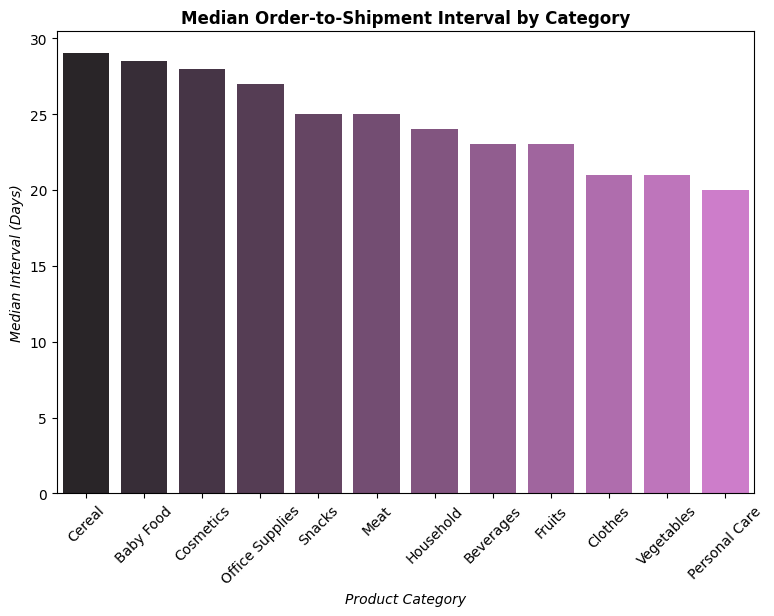

In [ ]:
median_interval_by_category = df.groupby("item_type")["interval"].median().sort_values(ascending = False).reset_index()

plt.figure(figsize = (9, 6))
sns.barplot(data = median_interval_by_category, x = "item_type", y = "interval", hue = "item_type", palette="dark:orchid")
plt.title("Median Order-to-Shipment Interval by Category", fontweight = "bold")
plt.xlabel("Product Category", fontstyle = "italic")
plt.ylabel("Median Interval (Days)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

Найдовший медіанний інтервал між замовленням та його відвантаженням у категоріях Cereal, Baby Food та Cosmetics.

##### За країнами та регіонами

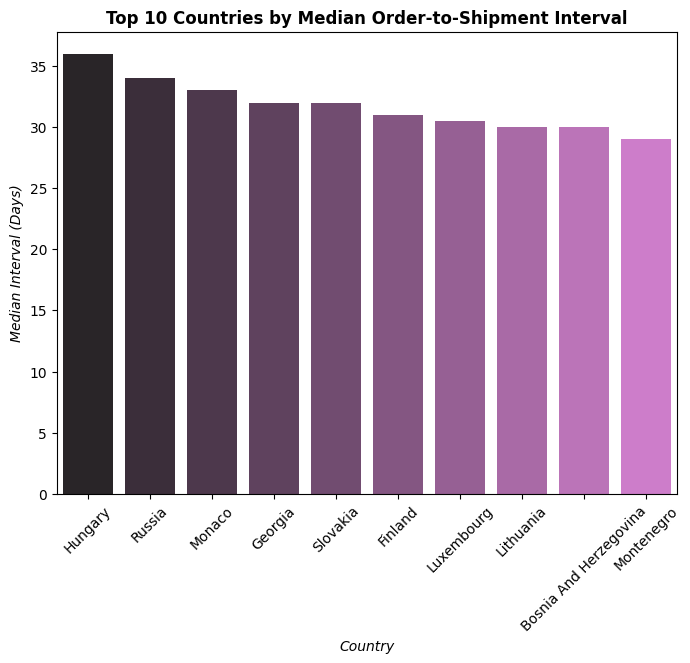

In [ ]:
median_interval_by_country = df.groupby("country_name")["interval"].median().sort_values(ascending = False).reset_index()
median_interval_by_country = median_interval_by_country[median_interval_by_country["country_name"] != "Unknown"]
top_10_countries_by_median_interval = median_interval_by_country.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_10_countries_by_median_interval, x = "country_name", y = "interval", hue = "country_name", palette="dark:orchid")
plt.title("Top 10 Countries by Median Order-to-Shipment Interval", fontweight = "bold")
plt.xlabel("Country", fontstyle = "italic")
plt.ylabel("Median Interval (Days)", fontstyle = "italic")
plt.xticks(rotation=45)
plt.show()

In [ ]:
fig = px.choropleth(
    median_interval_by_country,
    locations="country_name",
    locationmode="country names",
    color="interval",
    title="<b>Median Order-to-Shipment Interval by Country</b>",
    color_continuous_scale="Sunset")

fig.update_layout(width=800, height=500)

fig.show()

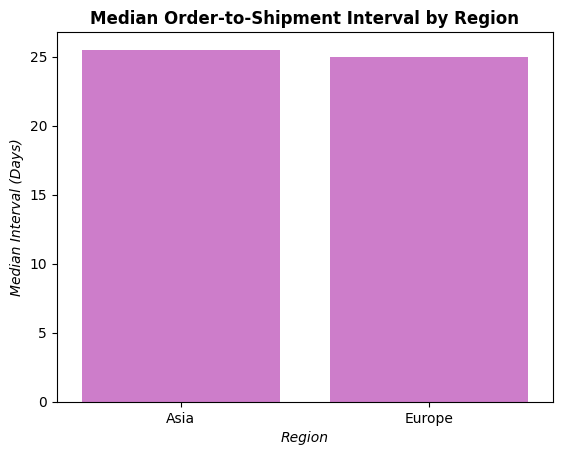

In [ ]:
median_interval_by_region = df.groupby("region")["interval"].median().sort_values(ascending = False).reset_index()
median_interval_by_region = median_interval_by_region[median_interval_by_region["region"] != "Unknown"]

sns.barplot(data = median_interval_by_region, x = "region", y = "interval", color = "orchid")
plt.title("Median Order-to-Shipment Interval by Region", fontweight = "bold")
plt.xlabel("Region", fontstyle = "italic")
plt.ylabel("Median Interval (Days)", fontstyle = "italic")
plt.show()

Медіанний інтервал між замовленням та його відвантаженням приблизно однаковий.

### Дослідження залежності прибутку від часу, необхідного на відвантаження товарів

In [ ]:
print(f"Коефіцієнт кореляції Пірсона між прибутком та інтервалом між замовленням і його відвантаженням: {df['profit'].corr(df['interval'])}")

Коефіцієнт кореляції Пірсона між прибутком та інтервалом між замовленням і його відвантаженням: 0.06066222159908734


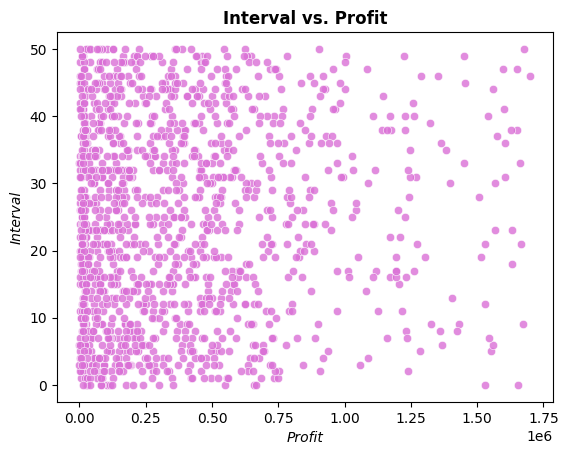

In [ ]:
sns.scatterplot(data = df, x = "profit", y = "interval", color = "orchid", alpha = 0.8)
plt.title("Interval vs. Profit", fontweight = "bold")
plt.xlabel("Profit", fontstyle = "italic")
plt.ylabel("Interval", fontstyle = "italic")
plt.show()

З отриманих результатів бачимо, що залежності прибутку від інтервалу між замовленням та відвантаженням немає.

### Динаміка продажів у часі

##### Динаміка доходів за категоріями

In [ ]:
df["month"] = df["order_date"].dt.to_period("M").dt.to_timestamp()
revenue_by_category = df.groupby(["month", "item_type"])["revenue"].sum().reset_index()

fig = px.line(
    revenue_by_category,
    x="month",
    y="revenue",
    color="item_type",
    title="<b>Revenue Dynamics by Product Category</b>",
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Revenue ($)",
    legend_title="Category",
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": category,
                    "args": [{"visible": [cat == category for cat in revenue_by_category["item_type"].unique()]},
                             {"title": f"<b>Revenue Dynamics: {category}</b>"}]
                }
                for category in revenue_by_category["item_type"].unique()
            ],
            "direction": "down",
            "showactive": True,
        }
    ]
)

fig.show()


Доходи категорій коливаються протягом часу, немає чіткої тенденції росту або падіння. Найбільше доходів приносить категорія Office Supplies, доходи у цій категорії досягають піку у листопаді 2015 року.

##### Динаміка прибутків за категоріями

In [ ]:
profit_by_category = df.groupby(["month", "item_type"])["profit"].sum().reset_index()

fig = px.line(
    profit_by_category,
    x="month",
    y="profit",
    color="item_type",
    title="<b>Profit Dynamics by Product Category</b>",
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Profit ($)",
    legend_title="Category",
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": category,
                    "args": [{"visible": [cat == category for cat in profit_by_category["item_type"].unique()]},
                             {"title": f"<b>Profit Dynamics: {category}</b>"}]
                }
                for category in profit_by_category["item_type"].unique()
            ],
            "direction": "down",
            "showactive": True,
        }
    ]
)

fig.show()


Прибутки категорій коливаються протягом часу. Лідером є категорія Cosmetics, для якої у березні 2014 року спостерігається пік прибутків.

##### Динаміка доходів за країнами

In [ ]:
revenue_by_country = df.groupby(["month", "country_name"])["revenue"].sum().reset_index()

fig = px.line(
    revenue_by_country,
    x="month",
    y="revenue",
    color="country_name",
    title="<b>Revenue Dynamics by Country</b>",
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Revenue ($)",
    legend_title="Country",
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": country,
                    "args": [{"visible": [c == country for c in revenue_by_country["country_name"].unique()]},
                             {"title": f"<b>Revenue Dynamics: {country}</b>"}]
                }
                for country in revenue_by_country["country_name"].unique()
            ],
            "direction": "down",
            "showactive": True,
        }
    ]
)

fig.show()


##### Динаміка прибутків за країнами

In [ ]:
profit_by_country = df.groupby(["month", "country_name"])["profit"].sum().reset_index()

fig = px.line(
    profit_by_country,
    x="month",
    y="profit",
    color="country_name",
    title="<b>Profit Dynamics by Country</b>",
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Profit ($)",
    legend_title="Country",
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": country,
                    "args": [{"visible": [c == country for c in profit_by_country["country_name"].unique()]},
                             {"title": f"<b>Profit Dynamics: {country}</b>"}]
                }
                for country in profit_by_country["country_name"].unique()
            ],
            "direction": "down",
            "showactive": True,
        }
    ]
)

fig.show()


Доходи та прибутки для країн є мінливими, з численними зростаннями і падіннями.

##### Доходи за регіонами

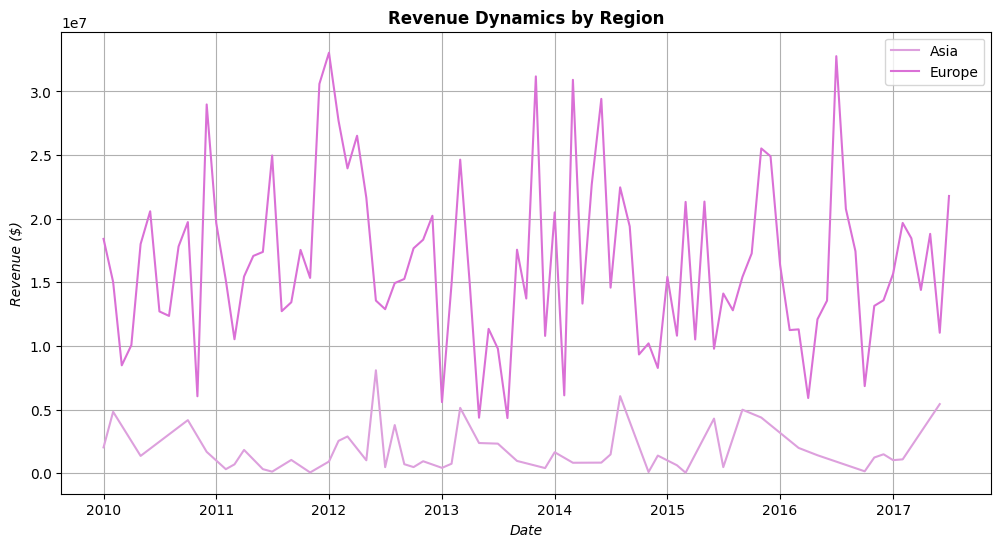

In [ ]:
revenue_by_region = df[df["region"] != "Unknown"].groupby(["month", "region"])["revenue"].sum().reset_index()

colors = ["plum", "orchid"]

plt.figure(figsize=(12, 6))
for color, region in zip(colors, revenue_by_region["region"].unique()):
    region_data = revenue_by_region[revenue_by_region["region"] == region]
    plt.plot(region_data["month"], region_data["revenue"], label=region, color=color)

plt.title("Revenue Dynamics by Region", fontweight = "bold")
plt.xlabel("Date", fontstyle = "italic")
plt.ylabel("Revenue ($)",  fontstyle = "italic")
plt.legend()
plt.grid(True)
plt.show()

##### Прибутки за регіонами

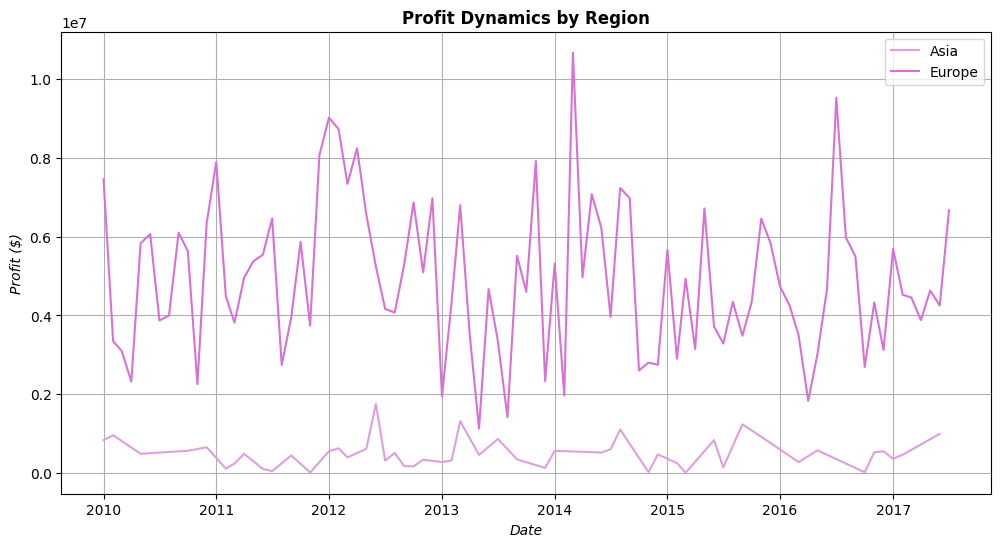

In [ ]:
profit_by_region = df[df["region"] != "Unknown"].groupby(["month", "region"])["profit"].sum().reset_index()

colors = ["plum", "orchid"]

plt.figure(figsize=(12, 6))
for color, region in zip(colors, profit_by_region["region"].unique()):
    region_data = profit_by_region[profit_by_region["region"] == region]
    plt.plot(region_data["month"], region_data["profit"], label=region, color=color)

plt.title("Profit Dynamics by Region", fontweight = "bold")
plt.xlabel("Date", fontstyle = "italic")
plt.ylabel("Profit ($)",  fontstyle = "italic")
plt.legend()
plt.grid(True)
plt.show()

Доходи та прибутки в Європі є більшими, але спостерігаються різкі коливання.

### Аналіз продажів за днями тижня

In [ ]:
df["weekday"] = df["order_date"].dt.weekday
category_weekday_dynamics = df.groupby(["weekday", "item_type"])["units_sold"].sum()
weekday_names = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
category_weekday_dynamics.rename(index=weekday_names, level=0, inplace=True)
category_weekday_dynamics = category_weekday_dynamics.reset_index()

fig = px.line(
    category_weekday_dynamics,
    x="weekday",
    y="units_sold",
    color="item_type",
    title="<b>Weekly Dynamics by Category</b>",
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_layout(
    xaxis_title="Day",
    yaxis_title="Units Sold",
    legend_title="Category",
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": category,
                    "args": [{"visible": [cat == category for cat in category_weekday_dynamics["item_type"].unique()]},
                             {"title": f"<b>Units Sold: {category}</b>"}]
                }
                for category in category_weekday_dynamics["item_type"].unique()
            ],
            "direction": "down",
            "showactive": True,
        }
    ]
)

fig.show()


З отриманого графіка бачимо, що деякі товари мають тижневу сезонність. Наприклад, фрукти, овочі та напої активніше купують на вихідних та в понеділок. Косметику найактивніше купують у п'ятницю, а одяг - у вівторок. Для деяких типів товарів, наприклад, дитячого харчування, розподіл більш рівномірний.

### Загальні висновки

**Ключові метрики:**
- Загальна кількість замовлень: 1 330
- Загальна кількість проданих одиниць: 6 586 448
- Загальний дохід: 1.7 млрд дол.
- Загальний прибуток: 501.8 млн дол.
- Кількість охоплених країн: 45


**Аналіз продажів:**
- Найприбутковіші категорії: Cosmetics, Office Supplies та Household.
- Найактивніші країни: Андорра, Україна та Мальта.
- Канали збуту (онлайн та офлайн) рівнозначні у прибутковості.

Залежність прибутку від інтервалу між замовленням та відправленням відсутня.